## Imports

In [1]:
import tensorflow as tf
from glob import glob
from os.path import join
from tensorflow.keras import layers, models
import xarray as xr
import pandas as pd
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import imports.GDL_layers as GDL_layers

2022-08-22 09:24:16.600272: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load data

In [2]:
# Find a list of all the datafiles
patch_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/"
patch_files = sorted(glob(join(patch_path, "*.nc")))
patch_ds = xr.open_dataset(patch_files[0])
csv_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/"
csv_files = sorted(glob(join(csv_path, "track_step_*.csv")))
meta_ds = pd.read_csv(csv_files[0])

In [3]:
patch_files[0]

'/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20101024-0000_d01_model_patches.nc'

In [4]:
int(150*.8)

120

In [5]:
patch_files[149]

'/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20120614-0000_d01_model_patches.nc'

In [6]:
patch_ds

<xarray.Dataset>
Dimensions:           (p: 370, row: 144, col: 144)
Coordinates:
  * p                 (p) int32 0 1 2 3 4 5 6 7 ... 363 364 365 366 367 368 369
  * row               (row) int32 0 1 2 3 4 5 6 ... 137 138 139 140 141 142 143
  * col               (col) int32 0 1 2 3 4 5 6 ... 137 138 139 140 141 142 143
Data variables: (12/26)
    lon               (p, row, col) float32 ...
    lat               (p, row, col) float32 ...
    i                 (p, row, col) int32 ...
    j                 (p, row, col) int32 ...
    x                 (p, row, col) float32 ...
    y                 (p, row, col) float32 ...
    ...                ...
    MLCAPE_prev       (p, row, col) float32 ...
    USHR6_prev        (p, row, col) float32 ...
    VSHR6_prev        (p, row, col) float32 ...
    SBLCL_prev        (p, row, col) float32 ...
    U_BUNK_prev       (p, row, col) float32 ...
    V_BUNK_prev       (p, row, col) float32 ...
Attributes: (12/36)
    Conventions:             CF-1.6
    title:                   NCARSTORM Storm Patches for run 20101024-0000 me...
    object_variable:         REFL_COM
    start_hour:              12
    end_hour:                35
    HRRR_alt_end_hour:       46
    ...                      ...
    single_step:             True
    label_type:              gamma
    model_map_file:          /glade/work/cbecker/hagelslag/mapfiles/ncar_stor...
    mask_file:               None
    run_date_format:         %Y%m%d-%H%M
    json:                    False

In [7]:
meta_ds

,Step_ID,Track_ID,Ensemble_Name,Ensemble_Member,Run_Date,Valid_Date,Forecast_Hour,Valid_Hour_UTC,Duration,Centroid_Lon,...,eccentricity,major_axis_length,minor_axis_length,orientation,Matched,Max_Hail_Size,Num_Matches,Shape,Location,Scale
0,d01_REFL_COM_20101024-0000_12_13_000_00,d01_REFL_COM_20101024-0000_12_13_000,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 12:00:00+00:00,12,12,1,-98.41019,...,0.90735,51.23550,21.53869,1.41172,0,0,0,0,0,0
1,d01_REFL_COM_20101024-0000_12_13_000_01,d01_REFL_COM_20101024-0000_12_13_000,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 13:00:00+00:00,13,13,2,-97.69198,...,0.85356,26.92719,14.02906,1.13923,0,0,0,0,0,0
2,d01_REFL_COM_20101024-0000_12_12_001_00,d01_REFL_COM_20101024-0000_12_12_001,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 12:00:00+00:00,12,12,1,-95.15486,...,0.71815,8.65894,6.02569,0.74301,0,0,0,0,0,0
3,d01_REFL_COM_20101024-0000_12_13_002_00,d01_REFL_COM_20101024-0000_12_13_002,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 12:00:00+00:00,12,12,1,-94.39792,...,0.58687,7.89825,6.39509,-1.28875,0,0,0,0,0,0
4,d01_REFL_COM_20101024-0000_12_13_002_01,d01_REFL_COM_20101024-0000_12_13_002,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 13:00:00+00:00,13,13,2,-94.21008,...,0.91899,27.65443,10.90375,0.32912,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,d01_REFL_COM_20101024-0000_35_35_238_00,d01_REFL_COM_20101024-0000_35_35_238,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-25 11:00:00+00:00,35,11,1,-85.94177,...,0.44428,6.31100,5.65396,1.29480,0,0,0,0,0,0
366,d01_REFL_COM_20101024-0000_35_35_239_00,d01_REFL_COM_20101024-0000_35_35_239,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-25 11:00:00+00:00,35,11,1,-85.16997,...,0.85947,79.05277,40.41106,0.12811,0,0,0,0,0,0
367,d01_REFL_COM_20101024-0000_35_35_240_00,d01_REFL_COM_20101024-0000_35_35_240,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-25 11:00:00+00:00,35,11,1,-88.18374,...,0.92145,18.05184,7.01316,0.99009,0,0,0,0,0,0
368,d01_REFL_COM_20101024-0000_35_35_241_00,d01_REFL_COM_20101024-0000_35_35_241,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-25 11:00:00+00:00,35,11,1,-82.50549,...,0.93744,14.44305,5.02817,-0.19595,0,0,0,0,0,0


In [8]:
# Pull selected variables from patch files and join into a single DataSet
num_files = 150
train_split = int(num_files*0.7)
val_split = int(num_files*0.8)
variables = ["REFL_COM_curr", "masks"]
data_list = []
for p, patch_file in enumerate(patch_files[0:train_split]):
    if p % 10 == 0:
        print(f'Train {p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_train = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)
train_masks = xr.concat(data_list, dim="p")["masks"]
data_list = []
for p, patch_file in enumerate(patch_files[train_split:val_split]):
    if p % 10 == 0:
        print(f'Validation {train_split + p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_val = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)
val_masks = xr.concat(data_list, dim="p")["masks"]
data_list = []
for p, patch_file in enumerate(patch_files[val_split:num_files]):
    if p % 10 == 0:
        print(f'Test {val_split + p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_test = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)
test_masks = xr.concat(data_list, dim="p")["masks"]

Train 0, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20101024-0000_d01_model_patches.nc
Train 10, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110201-0000_d01_model_patches.nc
Train 20, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110326-0000_d01_model_patches.nc
Train 30, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110414-0000_d01_model_patches.nc
Train 40, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110425-0000_d01_model_patches.nc
Train 50, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110522-0000_d01_model_patches.nc
Train 60, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110605-0000_d01_model_patches.nc
Train 70, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110615-0000_d01_model_patches.nc
Train 80, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_2

In [9]:
# Pull variables from csv files and join into an array
csv_variables = ["major_axis_length", "minor_axis_length"]
csv_data_list = []
for p, csv_file in enumerate(csv_files[0:train_split]):
    if p % 10 == 0:
        print(f'Train {p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_train = xr.concat(csv_data_list, dim="p").to_array().transpose()
csv_data_list = []
for p, csv_file in enumerate(csv_files[train_split:val_split]):
    if p % 10 == 0:
        print(f'Validation {train_split + p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_val = xr.concat(csv_data_list, dim="p").to_array().transpose()
csv_data_list = []
for p, csv_file in enumerate(csv_files[val_split:num_files]):
    if p % 10 == 0:
        print(f'Test {val_split + p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_test = xr.concat(csv_data_list, dim="p").to_array().transpose()

Train 0, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20101024-0000.csv
Train 10, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110201-0000.csv
Train 20, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110326-0000.csv
Train 30, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110414-0000.csv
Train 40, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110425-0000.csv
Train 50, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110522-0000.csv
Train 60, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110605-0000.csv
Train 70, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110615-0000.csv
Train 80, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTO

In [10]:
print(input_train.shape)
print(input_val.shape)
print(input_test.shape)
print(output_train.shape)
print(output_val.shape)
print(output_test.shape)

(34061, 144, 144, 1)
(4300, 144, 144, 1)
(12985, 144, 144, 1)
(34061, 2)
(4300, 2)
(12985, 2)


## Normalize data

In [10]:
# Normalize the input data
scale_stats = pd.DataFrame(index=[0], columns=["mean", "sd"])
scale_stats.loc[0, "mean"] = input_train.mean()
scale_stats.loc[0, "sd"] = input_train.std()
input_train_norm = (input_train - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]
input_val_norm = (input_val - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]
input_test_norm = (input_test - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]

In [11]:
# Normalize the output data
output_scale_stats = pd.DataFrame(index=range(output_train.shape[-1]), columns=["mean", "sd"])
output_scale_stats.loc[:, "mean"] = output_train.mean(dim="p")
output_scale_stats.loc[:, "sd"] = output_train.std(dim="p")
output_train_norm = xr.DataArray(coords=output_train.coords, dims=output_train.dims)
output_val_norm = xr.DataArray(coords=output_val.coords, dims=output_val.dims)
output_test_norm = xr.DataArray(coords=output_test.coords, dims=output_test.dims)
for i in range(output_train.shape[-1]):
    output_train_norm[:, i] = (output_train[:, i] - output_scale_stats.loc[i, "mean"]) / output_scale_stats.loc[i, "sd"]
    output_val_norm[:, i] = (output_val[:, i] - output_scale_stats.loc[i, "mean"]) / output_scale_stats.loc[i, "sd"]
    output_test_norm[:, i] = (output_test[:, i] - output_scale_stats.loc[i, "mean"]) / output_scale_stats.loc[i, "sd"]

## Train Models

In [13]:
ricnn_models = [models.Sequential() for i in range(6)]
filters = [32, 64, 64, 128]
for inv_layer in range(6):
    ricnn_models[inv_layer].add(GDL_layers.RotEquivConv2D(filters[0], (3, 3), rot_axis=False, input_shape=(144, 144, 1)))
    ricnn_models[inv_layer].add(GDL_layers.RotEquivPool2D((2, 2)))
    for layer, filts in enumerate(filters):
        if layer < inv_layer:
            ricnn_models[inv_layer].add(GDL_layers.RotEquivConv2D(filters[layer], (3, 3)))
            ricnn_models[inv_layer].add(GDL_layers.RotEquivPool2D((2, 2)))
        else:
            if layer == inv_layer:
                ricnn_models[inv_layer].add(GDL_layers.RotInvPool())
            ricnn_models[inv_layer].add(layers.Conv2D(filters[layer], (3, 3), activation='relu'))
            ricnn_models[inv_layer].add(layers.MaxPooling2D((2, 2)))
    ricnn_models[inv_layer].add(layers.Flatten())
    ricnn_models[inv_layer].add(layers.Dense(32, activation='relu'))
    ricnn_models[inv_layer].add(layers.Dense(2))
    ricnn_models[inv_layer].compile(
        optimizer='nadam',
        loss='mse'
    )

2022-08-21 12:27:13.548394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-21 12:27:14.147869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3e:00.0, compute capability: 7.0


In [14]:
ricnn_models[5].summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d_15 (RotEqu  (None, 142, 142, 4, 32)  320       
 ivConv2D)                                                       
                                                                 
 rot_equiv_pool2d_15 (RotEqu  (None, 71, 71, 4, 32)    0         
 ivPool2D)                                                       
                                                                 
 rot_equiv_conv2d_16 (RotEqu  (None, 69, 69, 4, 32)    9248      
 ivConv2D)                                                       
                                                                 
 rot_equiv_pool2d_16 (RotEqu  (None, 34, 34, 4, 32)    0         
 ivPool2D)                                                       
                                                                 
 rot_equiv_conv2d_17 (RotEqu  (None, 32, 32, 4, 64)   

In [15]:
ricnn_history = []
for inv_layer, model in enumerate(ricnn_models):
    ricnn_history.append(model.fit(x=input_train_norm, y=output_train_norm, epochs=10, validation_data=(input_val_norm, output_val_norm)))
    model.save(f"saved_models/rot_inv_hyper/inv_layer_{inv_layer}")
    K.clear_session()

Epoch 1/10


2022-08-21 12:27:21.968855: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1065/1065 [==============================] - 70s 53ms/step - loss: 0.3885 - val_loss: 0.1466
Epoch 2/10
1065/1065 [==============================] - 55s 52ms/step - loss: 0.2143 - val_loss: 0.1287
Epoch 3/10
1065/1065 [==============================] - 55s 52ms/step - loss: 0.1704 - val_loss: 0.1256
Epoch 4/10
1065/1065 [==============================] - 55s 52ms/step - loss: 0.1407 - val_loss: 0.1807
Epoch 5/10
1065/1065 [==============================] - 56s 52ms/step - loss: 0.1181 - val_loss: 0.1168
Epoch 6/10
1065/1065 [==============================] - 56s 53ms/step - loss: 0.1031 - val_loss: 0.1096
Epoch 7/10
1065/1065 [==============================] - 56s 52ms/step - loss: 0.0982 - val_loss: 0.1075
Epoch 8/10
1065/1065 [==============================] - 55s 52ms/step - loss: 0.0850 - val_loss: 0.0847
Epoch 9/10
1065/1065 [==============================] - 55s 52ms/step - loss: 0.0799 - val_loss: 0.0800
Epoch 10/10
1065/1065 [==============================] - 55s 51ms/step - lo

INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_0/assets


INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_0/assets


Epoch 1/10
1064/1065 [============================>.] - ETA: 0s - loss: 0.3373WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.


1065/1065 [==============================] - 73s 66ms/step - loss: 0.3373 - val_loss: 0.2502
Epoch 2/10
1065/1065 [==============================] - 70s 65ms/step - loss: 0.1917 - val_loss: 0.0848
Epoch 3/10
1065/1065 [==============================] - 69s 65ms/step - loss: 0.1313 - val_loss: 0.0763
Epoch 4/10
1065/1065 [==============================] - 69s 65ms/step - loss: 0.1092 - val_loss: 0.1197
Epoch 5/10
1065/1065 [==============================] - 69s 65ms/step - loss: 0.0916 - val_loss: 0.0679
Epoch 6/10
1065/1065 [==============================] - 70s 65ms/step - loss: 0.0844 - val_loss: 0.0659
Epoch 7/10
1065/1065 [==============================] - 70s 65ms/step - loss: 0.0780 - val_loss: 0.1006
Epoch 8/10
1065/1065 [==============================] - 69s 65ms/step - loss: 0.1002 - val_loss: 0.2363
Epoch 9/10
1065/1065 [==============================] - 69s 65ms/step - loss: 0.0815 - val_loss: 0.1478
Epoch 10/10
1065/1065 [==============================] - 68s 64ms/step - lo

INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_1/assets


INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_1/assets


Epoch 1/10
1064/1065 [============================>.] - ETA: 0s - loss: 0.3322WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.


1065/1065 [==============================] - 77s 69ms/step - loss: 0.3321 - val_loss: 0.1297
Epoch 2/10
1065/1065 [==============================] - 74s 70ms/step - loss: 0.1882 - val_loss: 0.0960
Epoch 3/10
1065/1065 [==============================] - 74s 69ms/step - loss: 0.1165 - val_loss: 0.0732
Epoch 4/10
1065/1065 [==============================] - 73s 69ms/step - loss: 0.0920 - val_loss: 0.0605
Epoch 5/10
1065/1065 [==============================] - 73s 69ms/step - loss: 0.0755 - val_loss: 0.0597
Epoch 6/10
1065/1065 [==============================] - 74s 69ms/step - loss: 0.0663 - val_loss: 0.0589
Epoch 7/10
1065/1065 [==============================] - 74s 69ms/step - loss: 0.0551 - val_loss: 0.0558
Epoch 8/10
1065/1065 [==============================] - 73s 69ms/step - loss: 0.0521 - val_loss: 0.0556
Epoch 9/10
1065/1065 [==============================] - 73s 69ms/step - loss: 0.0442 - val_loss: 0.0482
Epoch 10/10
1065/1065 [==============================] - 73s 69ms/step - lo

INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_2/assets


INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_2/assets


Epoch 1/10
1064/1065 [============================>.] - ETA: 0s - loss: 0.2852WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.


1065/1065 [==============================] - 82s 73ms/step - loss: 0.2851 - val_loss: 0.1036
Epoch 2/10
1065/1065 [==============================] - 77s 73ms/step - loss: 0.1357 - val_loss: 0.0728
Epoch 3/10
1065/1065 [==============================] - 77s 72ms/step - loss: 0.0959 - val_loss: 0.0650
Epoch 4/10
1065/1065 [==============================] - 77s 72ms/step - loss: 0.0724 - val_loss: 0.0673
Epoch 5/10
1065/1065 [==============================] - 77s 72ms/step - loss: 0.0603 - val_loss: 0.0783
Epoch 6/10
1065/1065 [==============================] - 77s 73ms/step - loss: 0.0492 - val_loss: 0.1613
Epoch 7/10
1065/1065 [==============================] - 77s 73ms/step - loss: 0.0421 - val_loss: 0.0816
Epoch 8/10
1065/1065 [==============================] - 77s 72ms/step - loss: 0.0386 - val_loss: 0.0563
Epoch 9/10
1065/1065 [==============================] - 77s 72ms/step - loss: 0.0348 - val_loss: 0.0594
Epoch 10/10
1065/1065 [==============================] - 77s 72ms/step - lo

INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_3/assets


INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_3/assets


Epoch 1/10
1064/1065 [============================>.] - ETA: 0s - loss: 0.3774WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.


1065/1065 [==============================] - 85s 75ms/step - loss: 0.3773 - val_loss: 0.2091
Epoch 2/10
1065/1065 [==============================] - 79s 74ms/step - loss: 0.1739 - val_loss: 0.0823
Epoch 3/10
1065/1065 [==============================] - 79s 74ms/step - loss: 0.1140 - val_loss: 0.0706
Epoch 4/10
1065/1065 [==============================] - 78s 74ms/step - loss: 0.0898 - val_loss: 0.0666
Epoch 5/10
1065/1065 [==============================] - 78s 73ms/step - loss: 0.0671 - val_loss: 0.0657
Epoch 6/10
1065/1065 [==============================] - 78s 73ms/step - loss: 0.0575 - val_loss: 0.0488
Epoch 7/10
1065/1065 [==============================] - 78s 73ms/step - loss: 0.0512 - val_loss: 0.0478
Epoch 8/10
1065/1065 [==============================] - 78s 74ms/step - loss: 0.0416 - val_loss: 0.0957
Epoch 9/10
1065/1065 [==============================] - 78s 73ms/step - loss: 0.0377 - val_loss: 0.0504
Epoch 10/10
1065/1065 [==============================] - 79s 74ms/step - lo

INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_4/assets


Epoch 1/10
1064/1065 [============================>.] - ETA: 0s - loss: 0.3060WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.


1065/1065 [==============================] - 83s 73ms/step - loss: 0.3059 - val_loss: 0.2189
Epoch 2/10
1065/1065 [==============================] - 78s 73ms/step - loss: 0.1390 - val_loss: 0.0936
Epoch 3/10
1065/1065 [==============================] - 77s 72ms/step - loss: 0.0920 - val_loss: 0.0565
Epoch 4/10
1065/1065 [==============================] - 77s 73ms/step - loss: 0.0675 - val_loss: 0.0613
Epoch 5/10
1065/1065 [==============================] - 77s 72ms/step - loss: 0.0564 - val_loss: 0.0873
Epoch 6/10
1065/1065 [==============================] - 77s 72ms/step - loss: 0.0446 - val_loss: 0.0560
Epoch 7/10
1065/1065 [==============================] - 77s 73ms/step - loss: 0.0406 - val_loss: 0.0460
Epoch 8/10
1065/1065 [==============================] - 77s 72ms/step - loss: 0.0357 - val_loss: 0.0500
Epoch 9/10
1065/1065 [==============================] - 77s 72ms/step - loss: 0.0314 - val_loss: 0.0400
Epoch 10/10
1065/1065 [==============================] - 77s 72ms/step - lo

INFO:tensorflow:Assets written to: saved_models/rot_inv_hyper/inv_layer_5/assets


(0.0, 0.40638466998934747)

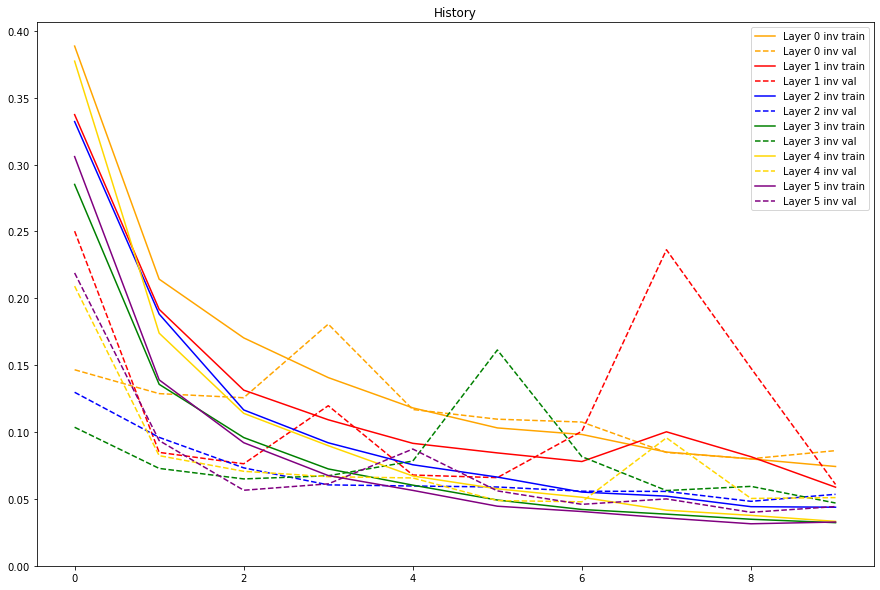

In [19]:
F, ax = plt.subplots(1, 1, figsize=(15, 10))
colors = ['orange', 'red', 'blue', 'green', 'gold', 'purple']
for i in range(6):
    ax.plot(ricnn_history[i].history['loss'], color=colors[i], label = f'Layer {i} inv train')
    ax.plot(ricnn_history[i].history['val_loss'], color=colors[i], label = f'Layer {i} inv val', linestyle='dashed')
plt.legend()
ax.set_title("History")
ax.set_ylim(bottom=0)